**Lab 02: Softmax Regression - Model Implementation**

**Group 09:** 
1. Bùi Huy Giáp - 23127289
2. Lê Minh Đức - 23127351
3. Vũ Tiến Dũng - 23127354
4. Đinh Xuân Khương - 23127398
5. Nguyễn Đồng Thanh - 23127538 

---

## 1. Giới thiệu
Ở notebook này, nhóm sẽ thực hiện xây dựng mô hình Softmax Regression bằng `Numpy`. Softmax Regression là mô hình khái quát hóa từ Logistic Regression. Theo yêu cầu của đồ án, nhóm sẽ thực hiện huấn luyện và đánh giá mô hình Softmax Regression bằng tập dữ liệu **MNIST**.

Trước hết cùng tìm hiểu và nắm rõ các khái niệm, công thức toán học sau:
1.  **Hàm điểm tuyến tính (giả thuyết mô hình):** $z = Wx + b$
2.  **Hàm Softmax:** Chuyển đổi các điểm số thô thành xác suất.
3.  **Hàm mất mát Cross-Entropy:** Đo lường sự khác biệt giữa xác suất dự đoán và nhãn thực tế.
4.  **Gradient Descent:** Cập nhật các tham số ($W, b$) để giảm thiểu sai số. 

**Note**: Do đây cũng là file ghi chép quá trình nhóm tự học, nên có những dòng ghi chép khá giống độc thoại nội tâm, hoặc tự hỏi tự phản biện, các thầy thông cảm ạ.

## 2. Công thức toán học

### 2.1. Giả thuyết mô hình (Hàm tính điểm)

Nhóm tìm hiểu và thấy hàm chấm điểm mà người ta thường dùng là hàm tuyến tính:

$$
z = w \cdot x + b
$$

**Câu hỏi đặt ra:** *Tại sao $z(x)$ lại là hàm tuyến tính chứ không phải dạng hàm khác?*  

Trước hết, softmax là sự tổng quát hóa của logistic, mà logistic cũng dùng hàm chấm điểm tuyến tính. Do đó, nếu thắc mắc thì lẽ ra phải thắc mắc từ lúc học logistic chứ nhỉ !? :> (hi giờ mới để ý nên đào sâu thử)

---

**Vào trọng tâm: Tại sao hàm chấm điểm lại là *tuyến tính*?**

Sau khi tìm hiểu, nhóm rút ra các lý do sau:

---

**1. Hàm chấm điểm tuyến tính đảm bảo tính tối ưu lồi**

- Bài toán tối ưu chỉ có một điểm cực tiểu toàn cục.  
- Điều này giúp quá trình học **ổn định, nhanh hơn và dễ phân tích**.  
- Nếu dùng hàm phi tuyến cho phần tính điểm, mô hình có thể xuất hiện nhiều cực trị → khó học.

---

**2. Các trọng số $w_{k,j}$ có thể diễn giải được**

- Nhìn vào giá trị của $w_{k,j}$ ta có thể nói lên “tầm ảnh hưởng" của thuộc tính \(j\) lên lớp \(k\).  
- Điều này quan trọng trong các mô hình cần **tính giải thích**.

---

**3. Ranh giới quyết định đơn giản**

- Khi điểm số là hàm tuyến tính → ranh giới quyết định là:
  - 1 đường thẳng (2D),  
  - 1 mặt phẳng (3D),  
  - hoặc 1 siêu phẳng (nD).

- Nhờ đó:
  - Dễ quan sát, trực quan hóa và debug.
  - Tránh overfit ở một mức độ nào đó → mô hình học nhanh hơn.

---

**4. “Xây nhà thì xây từ những thứ cơ bản, đơn giản”**

- So với hàm phi tuyến, hàm tuyến tính \(y = a \cdot x + b\) đơn giản hơn và là hàm đơn giản nhất.
- Với Softmax Regression, chỉ cần hàm tính điểm tuyến tính là đủ để đạt:
  - độ chính xác tốt
  - tốc độ nhanh
  - cài đặt dễ
  - tốn ít tài nguyên

- Khi cảm thấy hàm tuyến tính không còn đủ chính xác:
  - Ta chuyển sang mạng nơ-ron (deep learning)
  - nơi hàm tối ưu *không còn lồi*, trọng số khó diễn giải
  - và việc tính toán phức tạp, tốn tài nguyên hơn

Dạng tổng quát:

$$
\phi(x) \rightarrow z = W\phi(x) + b \rightarrow \text{softmax}
$$

trong đó $\phi(x)$ là hàm phi tuyến.

---

### Liên quan: Softmax Regression là một Generalized Linear Model (GLM)

- Đây có thể là một lý do khác giải thích tại sao nó sử dụng **hàm chấm điểm tuyến tính** (từ tên đã là *linear* :>).
- Phần phi tuyến nằm ở công thức hàm Softmax.
- Softmax Regression chính là **mạng nơ-ron đơn giản nhất** (1 lớp).
- Trong mạng nơ-ron sâu, người ta giải quyết tính phi tuyến bằng cách:
  - xếp chồng nhiều lớp tuyến tính,
  - xen kẽ bởi các hàm kích hoạt phi tuyến.


**Đến với công thức tính điểm cho tập MNIST.**

Với một vector đầu vào $x \in \mathbb{R}^{d}$ (trong đó $d$ là số lượng đặc trưng, ví dụ ảnh $28 \times 28 = 784$ pixel), và với $K$ lớp (ở đây $K = 10$), mô hình tính một điểm tuyến tính (logit) cho mỗi lớp $k$:

$$
z_k = w_k^T x + b_k
$$

Ở dạng vector hóa cho một batch gồm $m$ mẫu $X \in \mathbb{R}^{m \times d}$, biểu diễn toán học chính xác là:

$$
Z = XW + \mathbf{1}_m b
$$

Trong đó:

- $W \in \mathbb{R}^{d \times K}$ là ma trận trọng số.  
- $b \in \mathbb{R}^{1 \times K}$ là vector bias.  
- $\mathbf{1}_m \in \mathbb{R}^{m \times 1}$ là vector cột gồm toàn các số 1.  
- $Z \in \mathbb{R}^{m \times K}$ chứa các giá trị logit.

Hạng tử $\mathbf{1}_m b$ thực hiện việc nhân (broadcast) để sao chép vector bias $b$ cho tất cả $m$ mẫu trong batch, tạo thành một ma trận kích thước $(m \times K)$ để có thể cộng hợp lệ với $XW$.


### 2.1.1. Ghi chú về triển khai code (Broadcasting)

Trong thực tế, khi triển khai bằng các thư viện Python như **NumPy** (hoặc TensorFlow/PyTorch), ta thường bỏ qua vector $\mathbf{1}_m$ và chỉ viết code (cả viết tài liệu mô tả) dưới dạng:

$$Z = XW + b$$

**Tại sao lại như vậy?**  
Điều này dựa vào cơ chế gọi là **Broadcasting**. Thư viện sẽ tự động nhận diện sự khác biệt kích thước giữa $XW$ $(m \times K)$ và $b$ $(1 \times K)$, và ngầm “kéo giãn” (broadcast) vector $b$ theo chiều $m$ để thực hiện phép cộng theo từng phần tử.

Do đó, trong code của chúng ta:

```python
# Code implementation
z = np.dot(X, self.W) + self.b


### 2.2. Hàm Softmax

Với một mẫu đơn có vector logit $z = [z_1, z_2, \dots, z_K]^T$, hàm Softmax sẽ biến đổi các điểm số này thành một phân phối xác suất $\hat{y}$ (trong đó các phần tử nằm trong khoảng $(0, 1)$ và tổng bằng 1):

$$
\hat{y}_k = \text{Softmax}(z)_k = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}
$$

Khi áp dụng cho ma trận logit $Z \in \mathbb{R}^{m \times K}$, phép biến đổi này được thực hiện **theo từng hàng** cho mỗi mẫu.

---

**Tính ổn định số (Numerical Stability):**  
Việc tính trực tiếp $e^{z_k}$ có thể gây tràn số nếu $z_k$ quá lớn. Để tránh điều này, ta sử dụng tính chất bất biến của Softmax khi cộng một hằng số. Ta trừ đi giá trị lớn nhất trong vector $z$ trước khi lấy lũy thừa:

$$
\text{Softmax}(z)_k = \frac{e^{z_k - c}}{\sum_{j=1}^{K} e^{z_j - c}}
$$

Trong đó $c = \max(z)$. Điều này đảm bảo số mũ lớn nhất là $0$ ($e^0 = 1$), giúp tránh hiện tượng tràn số.


Ở đây, ta sẽ cùng bàn luận hai câu hỏi cơ bản:  

---

**1. Tại sao cần Softmax?** 

Ta đã có hàm chấm điểm ở bên trên, nếu muốn phân loại thì chẳng phải chỉ cần lấy nhãn có điểm cao nhất là xong sao?

Đúng, nếu muốn phân loại thì chỉ cần lấy điểm cao nhất là xong. Nhưng ta không chỉ muốn phân loại, ta còn muốn:

1. **Diễn giải kết quả theo độ tự tin của mô hình**:  
   Chỉ xem xét điểm có hai vấn đề:  
   - Ta khó lòng thấy bức tranh tổng thể. Ví dụ: điểm cho nhãn A là 100, nhãn B là 60, nhãn C là 75 — ta chỉ thấy con số, nhưng không biết độ tự tin dành cho từng nhãn là bao nhiêu.  
   - Nếu lấy “điểm / tổng điểm” để chuẩn hoá thì không hợp lý vì điểm có thể âm.  

2. **Tính sai số để đánh giá mô hình**:  
   Khi dùng điểm thô, ta không có một thang đo thống nhất.  
   Softmax đưa kết quả về khoảng $(0, 1)$ với tổng bằng $1$, cho phép ta dùng các hàm mất mát chuẩn như cross-entropy.  

3. **Cải thiện mô hình một cách máy học và tự động**:  
   Softmax kết hợp với cross-entropy tạo ra gradient “đẹp”, ổn định:  
   $$
   \nabla = \hat{y} - y
   $$
   giúp mô hình học hiệu quả và tránh nhiều vấn đề số.

4. **Softmax tạo ra một phân phối xác suất hợp lý**:  
   Softmax không phải xác suất tuyệt đối theo nghĩa tần suất thống kê, nhưng nó mang đầy đủ đặc tính của xác suất trong mô hình hoá thống kê và hoàn toàn có thể diễn giải như mức độ tự tin.  

Tóm lại, Softmax giải quyết được ba nhu cầu quan trọng:  
- diễn giải,  
- tính loss chuẩn,  
- học máy ổn định.

---

**2. Tại sao lại là $e^x$?**

- $e^x$ giúp việc đạo hàm dễ dàng, “soft”, ổn định, và thuận tiện cho tối ưu hoá.  
- $e^x$ luôn dương, giúp loại bỏ vấn đề điểm âm khi chuẩn hoá.  
- $e^x$ nhạy cảm với sự thay đổi: chênh lệch nhỏ trong điểm thô có thể được “khuếch đại” rõ ràng trong xác suất. Ngoài ra thứ tự vẫn được giữ nguyên vì $e^x$ đồng biến theo x.

Nhưng đó chỉ là các lợi ích do ta nhận được sau này.  
Nguồn gốc của $e^x$ đến từ Logistic.  
Logistic ban đầu xuất phát từ nhu cầu mô hình hóa **log-odds** trong thống kê:

$$
\log\left( \frac{p}{1-p} \right) = x
$$

Suy ra:

$$
p = \frac{1}{1 + e^{-x}}
$$

Đây là cách Logistic ra đời.  
Softmax chính là tổng quát hoá Logistic cho trường hợp nhiều lớp nên cũng sử dụng $e^x$.

---

Ngoài các lý do trên, còn có yếu tố quan trọng khác:

**Mũ là hàm duy nhất thoả mãn các điều kiện của phân phối Gibbs**

Softmax thực chất là phân phối Boltzmann (Gibbs distribution):

$$
p_k = \frac{e^{z_k}}{\sum_j e^{z_j}}
$$

Đây là phân phối duy nhất thoả mãn nhiều tính chất tối ưu liên quan đến entropy trong thống kê và lý thuyết thông tin.

### 2.3. Hàm mất mát Cross-Entropy

Chúng ta tối ưu hóa mô hình bằng cách giảm thiểu hàm mất mát Cross-Entropy. Hàm này đo lường sự khác biệt giữa phân phối xác suất dự đoán $\hat{y}$ và phân phối nhãn thực tế $y$.

#### 2.3.1. Công thức Toán học

**1. Đối với một mẫu đơn lẻ (Single Sample):**
Giả sử ta có vector nhãn thực tế $y$ (đã one-hot encoding) và vector dự đoán $\hat{y}$:

$$L(y, \hat{y}) = - \sum_{k=1}^{K} y_k \log(\hat{y}_k)$$

Vì $y$ là one-hot (chỉ có một vị trí bằng 1, còn lại bằng 0), công thức rút gọn là:
$$L = - \log(\hat{y}_{đúng})$$

**2. Đối với cả Batch (m mẫu):**
Hàm chi phí (Cost Function) $J$ là trung bình cộng Loss của tất cả $m$ mẫu trong một batch:

$$J(W, b) = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y^{(i)}_k \log(\hat{y}^{(i)}_k)$$

**Rút gọn công thức:**
Vì $y^{(i)}$ là vector one-hot, nên tại mỗi mẫu $i$, tổng $\sum_{k=1}^{K}$ chỉ còn lại duy nhất giá trị của lớp đúng (các lớp khác nhân với 0 nên biến mất). Ta có:

$$J(W, b) = -\frac{1}{m} \sum_{i=1}^{m} \log(\hat{y}^{(i)}_{đúng})$$

*(Nghĩa là: Duyệt qua từng bức ảnh $i$ trong batch, chỉ lấy log xác suất của **lớp đúng** tương ứng, cộng tất cả lại rồi chia trung bình).*

---

#### 2.3.2. Ví dụ

Giả sử ta đang huấn luyện batch gồm **3 bức ảnh** ($m=3$) với bài toán phân loại **3 lớp** (Chó, Mèo, Gà).
* **Vector $y$ (Thực tế):** [Chó, Mèo, Gà]
* **Vector $\hat{y}$ (Máy dự đoán):** [Chó, Mèo, Gà]

| Mẫu (i) | Ảnh thực tế ($y$) | Máy dự đoán ($\hat{y}$) | Tính toán Loss ($-\log(\hat{y}_{đúng})$) | Nhận xét |
| :--- | :--- | :--- | :--- | :--- |
| **1** | **Chó** $[1, 0, 0]$ | $[0.9, 0.05, 0.05]$ | $-\log(0.9) \approx \mathbf{0.10}$ | Dự đoán đúng & tự tin $\rightarrow$ **Phạt nhẹ** |
| **2** | **Mèo** $[0, 1, 0]$ | $[0.1, 0.3, 0.6]$ | $-\log(0.3) \approx \mathbf{1.20}$ | Dự đoán sai (nghĩ là Gà) $\rightarrow$ **Phạt nặng** |
| **3** | **Gà** $[0, 0, 1]$ | $[0.1, 0.9, 0.0]$ | $-\log(0.0^*) \to \mathbf{+\infty}$ | Sai tuyệt đối (nghĩ là Mèo) $\rightarrow$ **Phạt cực đại** |

*(**) Trong thực tế code, ta cộng thêm số nhỏ $\epsilon$ để tránh lỗi log(0).*

**Tổng chi phí cho batch này:**
$$J = \frac{0.10 + 1.20 + \infty}{3} \approx \text{Rất lớn (Cần sửa tham số ngay lập tức)}$$

---

#### 2.3.3. Phân tích Chi tiết Cross-Entropy

**1. Ý nghĩa & Nguồn gốc:**
* **Nguồn gốc:** Xuất phát từ **Lý thuyết thông tin (Information Theory)** của Shannon. Khái niệm "Entropy" đo lường độ bất ngờ của thông tin.
* **Ý nghĩa:** Chúng ta muốn mô hình **không được ngạc nhiên** khi nhìn thấy đáp án đúng.
    * Nếu đáp án là "Chó" và máy dự đoán 99% là "Chó" $\rightarrow$ Độ ngạc nhiên thấp $\rightarrow$ Loss thấp.
    * Nếu đáp án là "Chó" mà máy dự đoán 1% là "Chó" $\rightarrow$ Ngạc nhiên cực độ $\rightarrow$ Loss cao.

**2.Ưu điểm**
* **Trừng phạt nặng lỗi "Ngu dốt mà tự tin":** Nhìn vào đồ thị hàm $-\log(x)$, khi xác suất dự đoán sai tiến về 0, giá trị lỗi bắn lên vô cực. Điều này ép mô hình phải sửa sai ngay lập tức, không được phép lơ là các mẫu khó.
* **Tương thích hoàn hảo với Softmax:** Khi tính đạo hàm (Gradient Descent), hàm Logarit ($\log$) triệt tiêu hàm Mũ ($e^x$) của Softmax. Điều này giúp gradient có dạng rất đẹp và đơn giản: $\hat{y} - y$ (Dự đoán - Thực tế), giúp thuật toán chạy ổn định và nhanh.
* **Hàm lồi (Convex):** Đảm bảo thuật toán Gradient Descent luôn tìm được điểm tối ưu toàn cục (global minimum), không bị kẹt ở các điểm tối ưu cục bộ.

**3. Nhược điểm:**
* **Nhạy cảm với nhiễu (Noise/Outliers):** Vì nó trừng phạt lỗi sai quá nặng, nếu trong dữ liệu huấn luyện có nhãn bị gán sai (ví dụ ảnh con mèo nhưng dán nhãn con chó), mô hình sẽ cố gắng "học vẹt" mẫu sai đó một cách cực đoan để giảm Loss, làm giảm độ chính xác tổng quát.

### 2.4. Gradient Descent

Sau khi xây dựng được hàm chi phí $J(W, b)$ , ta sử dụng thuật toán **Gradient Descent** để cập nhật các tham số $W$ và $b$ theo hướng làm cho $J$ giảm dần.  
Để làm được điều này, ta cần tính đạo hàm của $J$  theo từng tham số.

---

#### 2.4.1. Tính toán Gradient

Áp dụng **quy tắc chuỗi (Chain Rule)**, đạo hàm của hàm chi phí theo trọng số $W$  được viết dưới dạng:

$$
\frac{\partial J}{\partial W}
=
\frac{\partial J}{\partial Z}
\cdot
\frac{\partial Z}{\partial W}
$$
trong đó:
$$
Z = XW + \mathbf{1}_m b
$$

---

**1. Đạo hàm theo $Z$ (kết hợp Softmax & Cross-Entropy)**  

Hàm chi phí được định nghĩa như sau:
$$
J(W,b)= -\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K y_k^{(i)}\log\hat y_k^{(i)}
$$

Trước hết, ta xét hàm mất mát của **một mẫu duy nhất**:
$$
L^{(i)} = -\sum_{k=1}^K y_k^{(i)} \log \hat y_k^{(i)}
$$

Do $J$ là giá trị trung bình của $L^{(i)}$ trên $m$ mẫu, ta có:
$$
J = \frac{1}{m}\sum_{i=1}^m L^{(i)}
$$

Ta cần tính đạo hàm của $J$ theo $z_j^{(i)}$ — thành phần thứ $j$ của vector $Z$ tương ứng với mẫu thứ $i$:
$$
\frac{\partial J}{\partial z_j^{(i)}}
=
\frac{1}{m}\frac{\partial L^{(i)}}{\partial z_j^{(i)}}
$$

Áp dụng **quy tắc chuỗi (Chain Rule)** do $L^{(i)}$ phụ thuộc vào $z^{(i)}$ thông qua $\hat y^{(i)}$:
$$
\frac{\partial L^{(i)}}{\partial z_j^{(i)}}
=
\sum_{k=1}^K
\frac{\partial L^{(i)}}{\partial \hat y_k^{(i)}}
\cdot
\frac{\partial \hat y_k^{(i)}}{\partial z_j^{(i)}}
$$

Với Cross-Entropy Loss, ta có:
$$
\frac{\partial L^{(i)}}{\partial \hat y_k^{(i)}}
=
-\frac{y_k^{(i)}}{\hat y_k^{(i)}}
$$

Softmax có đạo hàm:
$$
\frac{\partial \hat y_k^{(i)}}{\partial z_j^{(i)}}
=
\hat y_k^{(i)}(\delta_{kj} - \hat y_j^{(i)})
$$

trong đó $\delta_{kj}$ là ký hiệu **Kronecker delta**, được định nghĩa là:
$$
\delta_{kj} =
\begin{cases}
1, & \text{khi } k = j \\
0, & \text{khi } k \ne j
\end{cases}
$$

Thay các biểu thức trên vào công thức đạo hàm, ta có:
$$
\frac{\partial L^{(i)}}{\partial z_j^{(i)}}
=
-\sum_{k=1}^K
y_k^{(i)}(\delta_{kj} - \hat y_j^{(i)})
$$

Tách tổng ở vế phải:
$$
\frac{\partial L^{(i)}}{\partial z_j^{(i)}}
=
-\sum_{k=1}^K y_k^{(i)}\delta_{kj}
+
\sum_{k=1}^K y_k^{(i)}\hat y_j^{(i)}
$$

Do $Y$ được mã hóa dưới dạng **one-hot**, ta có các tính chất sau:
$$
\sum_{k=1}^K y_k^{(i)} = 1,
\quad
\sum_{k=1}^K y_k^{(i)}\delta_{kj} = y_j^{(i)}
$$

Thay vào biểu thức trên:
$$
\frac{\partial L^{(i)}}{\partial z_j^{(i)}}
=
- y_j^{(i)} + \hat y_j^{(i)}
$$

hay tương đương:
$$
\frac{\partial L^{(i)}}{\partial z_j^{(i)}}
=
\hat y_j^{(i)} - y_j^{(i)}
$$


Quay lại đạo hàm của hàm chi phí $J$:
$$
\frac{\partial J}{\partial z_j^{(i)}}
=
\frac{1}{m}\left(\hat y_j^{(i)} - y_j^{(i)}\right)
$$

Gộp cho toàn bộ batch dưới dạng ma trận:
$$
\boxed{
\frac{\partial J}{\partial Z}
=
\frac{1}{m}(\hat Y - Y)
}
$$

Trong đó:
- $\hat Y \in \mathbb{R}^{m \times K}$ là ma trận xác suất dự đoán,
- $Y \in \{0,1\}^{m \times K}$ là ma trận nhãn one-hot.

Ký hiệu:
$$
\delta = \hat Y - Y
$$

$\delta$ biểu diễn **sai số trực tiếp giữa dự đoán và giá trị thực**.


---

**2. Đạo hàm của $Z$  theo $W$**

Do:
$$
Z = XW + \mathbf{1}_m b
$$

nên:
$$
\frac{\partial Z}{\partial W} = X^T
$$

---

**3. Gradient cuối cùng theo $W$**

$$
\frac{\partial J}{\partial W}
=
\frac{1}{m} X^T (\hat{Y} - Y)
=
\frac{1}{m} X^T \delta
$$

---

**4. Gradient theo bias $b$**

$$
\frac{\partial J}{\partial b}
=
\frac{1}{m} \mathbf{1}_m^T (\hat{Y} - Y)
=
\frac{1}{m} \sum_{i=1}^m \delta^{(i)}
$$


---

#### 2.4.2. Quy luật Cập nhật Tham số (Update Rules)

Sau khi đã biết "hướng dốc" (gradient), ta thực hiện bước đi xuống dốc để giảm lỗi. Ta dùng một siêu tham số $\alpha$ (Learning Rate - Tốc độ học) để kiểm soát độ lớn bước đi.

$$W := W - \alpha \frac{\partial J}{\partial W}$$

$$b := b - \alpha \frac{\partial J}{\partial b}$$

* Dấu trừ ($-$) nghĩa là đi ngược chiều đạo hàm (đạo hàm tăng thì ta giảm, đạo hàm giảm thì ta tăng) để tiến về điểm cực tiểu.

---

#### 2.4.3. Tổng kết logic trong Code (Implementation Note)

Khi viết code Python (Numpy), các công thức trên được viết gọn như sau:

```python
# 1. Tính sai số (Error term)
dz = y_pred - y_true

# 2. Tính Gradient (Chain rule)
m = X.shape[0]
dw = np.dot(X.T, dz) / m
db = np.sum(dz, axis=0, keepdims=True) / m

# 3. Cập nhật tham số (Gradient Descent step)
# self.lr là learning rate (alpha)
self.W -= self.lr * dw
self.b -= self.lr * db

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request # Standard library for downloading files

# Set random seed for reproducibility
np.random.seed(42)


# 3. Tải dữ liệu & Các hàm phụ

Để đảm bảo tính hiệu quả nhóm sẽ tải trực tiếp tập dữ liệu MNIST định dạng `.npz` (NumPy Zip) từ nguồn lưu trữ (Google Cloud) nếu file chưa tồn tại cục bộ.

Quy trình tiền xử lý dữ liệu bao gồm các bước sau:
1.  **Tải dữ liệu:** Đọc `x_train`, `y_train`, `x_test`, `y_test` từ file `.npz`.
2.  **Chuẩn hóa:** Đưa giá trị pixel từ khoảng $[0, 255]$ về $[0, 1]$. Điều này rất quan trọng để đảm bảo tính ổn định số học (numerical stability) khi thực hiện Gradient Descent.
3.  **Dát phẳng:** Biến đổi mỗi ảnh kích thước $28 \times 28$ thành một vector đặc trưng phẳng có kích thước $784$ ($28 \times 28 = 784$). Việc này cho phép thực hiện nhân ma trận trực tiếp với ma trận trọng số $W$.
4.  **Mã hóa One-hot (One-hot encoding):** Chuyển đổi nhãn dạng số nguyên (ví dụ: $y=5$) thành vector nhị phân (ví dụ: $[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]$) để phục vụ việc tính toán hàm mất mát Cross-Entropy.

In [ ]:
def load_mnist_data(data_path='../data/raw/mnist.npz'):
    """
    Tải và đọc tập dữ liệu MNIST từ file .npz.
    Nếu file chưa tồn tại, code sẽ tự động tải về từ Google Cloud.
    
    Args:
        data_path (str): Đường dẫn lưu/đọc file .npz.
        
    Returns:
        x_train, y_train, x_test, y_test: Các mảng Numpy.
        - x_train: (60000, 784) - Đã chuẩn hóa và Dát phẳng
        - y_train: (60000,)     - Nhãn gốc
        - x_test:  (10000, 784) - Đã chuẩn hóa và Dát phẳng
        - y_test:  (10000,)     - Nhãn gốc
    """
    # 1. Tải về nếu file chưa tồn tại
    url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz"
    
    # Đảm bảo thư mục tồn tại
    directory = os.path.dirname(data_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Đã tạo thư mục: {directory}")

    if not os.path.exists(data_path):
        print(f"Đang tải MNIST từ {url}...")
        try:
            urllib.request.urlretrieve(url, data_path)
            print("Tải xuống hoàn tất.")
        except Exception as e:
            print(f"Tải xuống thất bại: {e}")
            return None, None, None, None
    else:
        print(f"Đang đọc dữ liệu từ {data_path}...")

    # 2. Đọc dữ liệu bằng numpy
    with np.load(data_path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']

    print(f"Kích thước x_train gốc: {x_train.shape}") # Kỳ vọng: (60000, 28, 28)
    
    # 3. Tiền xử lý: Chuẩn hóa và Dát phẳng
    # Chia cho 255.0 để đưa về khoảng [0, 1] (kiểu float32)
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0
    
    # Dát phẳng ảnh: (N, 28, 28) -> (N, 784)
    # Bước này QUAN TRỌNG cho phép nhân ma trận: Z = XW + b
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    
    print(f"Kích thước x_train đã xử lý: {x_train.shape}") # Kỳ vọng: (60000, 784)
    print(f"Kích thước x_test đã xử lý: {x_test.shape}")   # Kỳ vọng: (10000, 784)
    
    return x_train, y_train, x_test, y_test

def one_hot_encode(y, num_classes=10):
    """
    Chuyển đổi nhãn số nguyên sang vector one-hot.
    Ví dụ: 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    
    Args:
        y (numpy.ndarray): Mảng chứa nhãn số nguyên (m,).
        num_classes (int): Số lượng lớp.
        
    Returns:
        numpy.ndarray: Ma trận one-hot (m, num_classes).
    """
    m = y.shape[0]
    one_hot = np.zeros((m, num_classes))
    for i in range(m):
        one_hot[i, y[i]] = 1
    return one_hot

# --- TẢI DỮ LIỆU ---
try:
    # Tải dữ liệu
    X_train_full, y_train_full, X_test, y_test = load_mnist_data()
    
    if X_train_full is not None:
        # Tạo tập Validation từ tập Train (5000 mẫu cuối)
        # Tách validation để tinh chỉnh siêu tham số mà không đụng vào tập Test
        val_size = 5000
        X_val = X_train_full[-val_size:]
        y_val = y_train_full[-val_size:]
        
        X_train = X_train_full[:-val_size]
        y_train = y_train_full[:-val_size]
        
        # Mã hóa one-hot cho nhãn
        y_train_enc = one_hot_encode(y_train)
        y_val_enc = one_hot_encode(y_val)
        y_test_enc = one_hot_encode(y_test)
        
        print("\nDữ liệu đã sẵn sàng để huấn luyện:")
        print(f"Tập Train:      X={X_train.shape}, y={y_train_enc.shape}")
        print(f"Tập Validation: X={X_val.shape}, y={y_val_enc.shape}")
        print(f"Tập Test:       X={X_test.shape}, y={y_test_enc.shape}")
    else:
        print("Không tải được dữ liệu.")

except Exception as e:
    print(f"Có lỗi xảy ra: {e}")

Đang đọc dữ liệu từ ../data/raw/mnist.npz...
Kích thước x_train gốc: (60000, 28, 28)
Kích thước x_train đã xử lý: (60000, 784)
Kích thước x_test đã xử lý: (10000, 784)

Dữ liệu đã sẵn sàng để huấn luyện:
Tập Train:      X=(55000, 784), y=(55000, 10)
Tập Validation: X=(5000, 784), y=(5000, 10)
Tập Test:       X=(10000, 784), y=(10000, 10)


## 3.1. Khám phá dữ liệu (EDA)

Trước khi đi vào xây dựng mô hình, nhóm thực hiện một số bước khám phá dữ liệu cơ bản để hiểu rõ hơn về đặc điểm của tập MNIST:
1.  **Trực quan hóa mẫu dữ liệu:** Hiển thị ngẫu nhiên một số bức ảnh từ tập huấn luyện để kiểm tra xem dữ liệu ảnh có đúng như mong đợi (chữ số viết tay) hay không.
2.  **Kiểm tra phân phối nhãn:** Xem xét số lượng mẫu của mỗi lớp (0-9) có đồng đều hay không. Việc mất cân bằng dữ liệu (imbalanced data) có thể ảnh hưởng xấu đến hiệu suất của mô hình.
3.  **Phân tích điểm ảnh trung bình:** Tính toán và hiển thị "ảnh trung bình" của mỗi lớp để xem mô hình tuyến tính có thể "nhìn thấy" được những đặc trưng gì chung nhất của từng số.

1. Một số mẫu ngẫu nhiên từ tập Train:


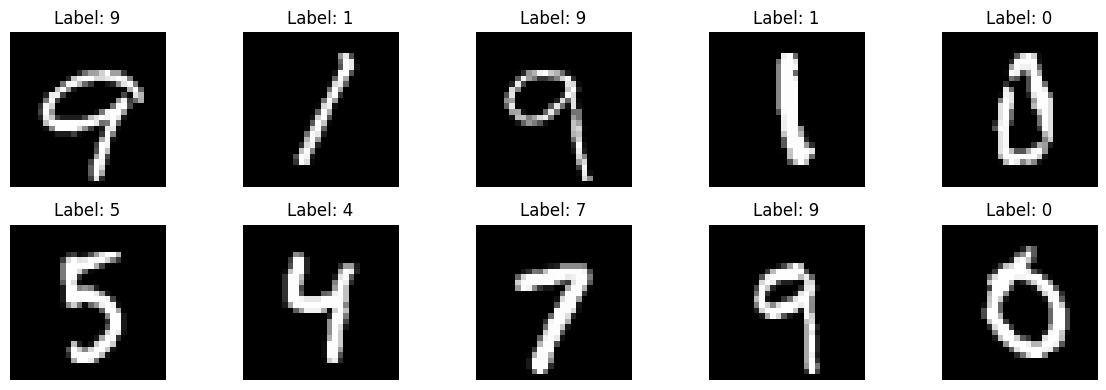


2. Phân phối dữ liệu các lớp:


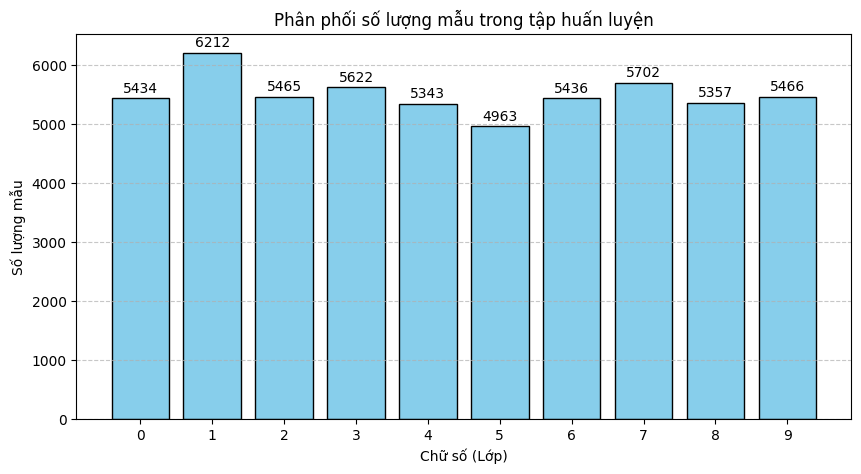


3. 'Bóng ma' trung bình của các chữ số:


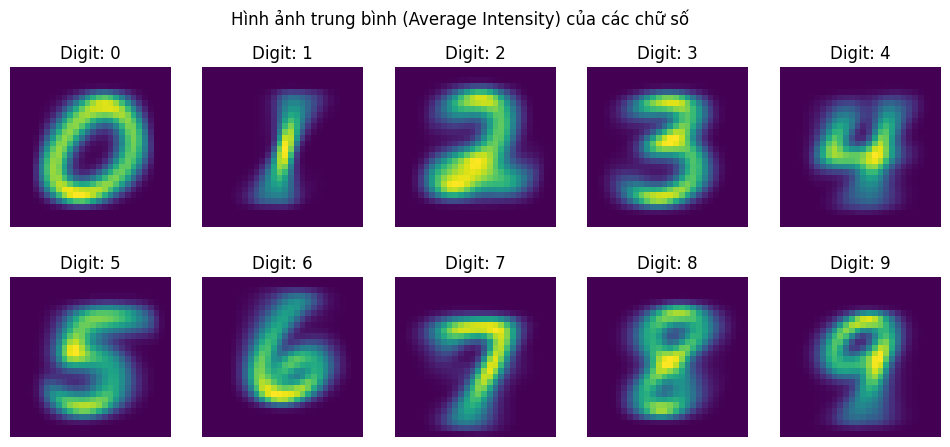

In [7]:
def visualize_samples(X, y, num_samples=10):
    """Hiển thị ngẫu nhiên các mẫu ảnh từ tập dữ liệu."""
    plt.figure(figsize=(12, 4))
    indices = np.random.choice(X.shape[0], num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        # Reshape lại từ 784 -> 28x28 để hiển thị ảnh
        img = X[idx].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {y[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_class_distribution(y):
    """Vẽ biểu đồ phân phối số lượng mẫu của từng lớp."""
    classes, counts = np.unique(y, return_counts=True)
    
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color='skyblue', edgecolor='black')
    plt.xlabel('Chữ số (Lớp)')
    plt.ylabel('Số lượng mẫu')
    plt.title('Phân phối số lượng mẫu trong tập huấn luyện')
    plt.xticks(classes)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Hiển thị số lượng cụ thể trên cột
    for i, count in enumerate(counts):
        plt.text(classes[i], count + 50, str(count), ha='center', va='bottom')
    plt.show()

def visualize_average_digits(X, y):
    """Tính và hiển thị ảnh trung bình của từng lớp số."""
    plt.figure(figsize=(12, 5))
    num_classes = 10
    
    for i in range(num_classes):
        # Lấy tất cả các ảnh thuộc lớp i
        X_class = X[y == i]
        # Tính trung bình dọc theo trục 0 (các mẫu)
        avg_img = np.mean(X_class, axis=0).reshape(28, 28)
        
        plt.subplot(2, 5, i + 1)
        plt.imshow(avg_img, cmap='viridis') # Dùng heatmap để thấy rõ vùng tập trung
        plt.title(f"Digit: {i}")
        plt.axis('off')
        
    plt.suptitle("Hình ảnh trung bình (Average Intensity) của các chữ số")
    plt.show()

# --- EDA ---
print("1. Một số mẫu ngẫu nhiên từ tập Train:")
visualize_samples(X_train, y_train)

print("\n2. Phân phối dữ liệu các lớp:")
plot_class_distribution(y_train)

print("\n3. 'Bóng ma' trung bình của các chữ số:")
visualize_average_digits(X_train, y_train)

## 3.2. Nhận xét từ kết quả khám phá dữ liệu

Dựa trên các biểu đồ trực quan hóa ở trên, nhóm rút ra các nhận xét quan trọng sau:

**1. Về đặc điểm mẫu dữ liệu (Random Samples):**
* Dữ liệu là ảnh xám (grayscale), kích thước $28 \times 28$ pixel. Chữ số nằm ở trung tâm ảnh nhưng có sự biến thiên lớn về nét viết (đậm/nhạt), độ nghiêng và kích thước.
* Nền ảnh màu đen (giá trị pixel xấp xỉ 0), chữ viết màu trắng (giá trị pixel cao). Điều này phù hợp với việc sử dụng giá trị pixel làm đặc trưng đầu vào, vì các pixel nền (0) sẽ không đóng góp vào tích vô hướng $W \cdot x$, giúp mô hình tập trung vào nét vẽ.

**2. Về sự cân bằng dữ liệu (Class Distribution):**
* Quan sát biểu đồ cột, ta thấy số lượng mẫu giữa các lớp (0-9) khá đồng đều, dao động từ khoảng **4.963** (số 5) đến **6.212** (số 1) mẫu.
* **Kết luận:** Tập dữ liệu này **khá cân bằng (balanced)**. Chúng ta không cần áp dụng các kỹ thuật tái lấy mẫu (Resampling) như Oversampling hay Undersampling. Độ chính xác (Accuracy) sẽ là một thước đo đáng tin cậy để đánh giá mô hình.

**3. Về hình ảnh trung bình (Average Intensity - "Ghost Images"):**
* Đây là phần quan trọng nhất để đánh giá khả năng của mô hình tuyến tính như Softmax Regression.
* **Các số dễ phân loại:** Các số như **0, 1, 6** có hình ảnh trung bình rất rõ nét, vùng pixel tập trung (màu vàng sáng) gọn gàng. Điều này nghĩa là hầu hết mọi người đều viết các số này theo cùng một cấu trúc không gian. Mô hình sẽ dễ dàng học được "khuôn mẫu" (template) của các số này.
* **Các số khó phân loại:** Các số như **5, 8, 2** có hình ảnh trung bình khá mờ và loang lổ (vùng màu xanh/tím chiếm diện tích rộng). Điều này cho thấy cách viết các số này rất đa dạng (ví dụ: số 2 có thể đuôi thẳng hoặc đuôi xoắn, số 5 có thể nét ngang dài hoặc ngắn).
* **Ý nghĩa đối với mô hình:** Vì Softmax Regression dựa trên sự chồng khớp của các pixel (template matching), nó sẽ gặp khó khăn với các số có độ biến thiên cao (như 5, 8). Đây chính là động lực để chúng ta thiết kế thêm các **Vector đặc trưng (Feature Vectors)** khác ngoài pixel thô (Raw Pixels) để cải thiện độ chính xác.

# 4. Softmax Regression Implementation

Đây là thành phần cốt lõi của dự án. Class này đóng gói các logic toán học đã được thiết lập ở Mục 2.

**Các chi tiết cài đặt chính:**
* **Ổn định số học (Numerical Stability):** Cài đặt hàm `softmax` bằng cách trừ đi giá trị lớn nhất trong vector logits để tránh tràn số (floating-point overflow, $e^{z_k} \to \infty$).
* **Vector hóa (Vectorization):** Sử dụng các phép toán ma trận của NumPy thay vì vòng lặp `for` để tăng tốc độ tính toán.
* **Mini-batch Gradient Descent:** Cập nhật trọng số sau khi xử lý một lô nhỏ các mẫu (ví dụ: 256 mẫu) thay vì toàn bộ tập dữ liệu. Điều này giúp cân bằng giữa tốc độ tính toán và sự ổn định của quá trình hội tụ.


In [8]:
class SoftmaxRegression:
    def __init__(self, n_features, n_classes, learning_rate=0.1):
        """
        Khởi tạo mô hình Softmax Regression cơ bản.

        Args:
            n_features (int): Số lượng đặc trưng đầu vào (ví dụ: 784).
            n_classes (int): Số lượng lớp đầu ra (ví dụ: 10).
            learning_rate (float): Tốc độ học (alpha).
        """
        self.n_features = n_features
        self.n_classes = n_classes
        self.lr = learning_rate
        self.losses = []
        
        # Khởi tạo trọng số (W) và bias (b)
        # Sử dụng phân phối chuẩn nhỏ để khởi tạo W
        self.W = np.random.randn(n_features, n_classes) * 0.01
        self.b = np.zeros((1, n_classes))

    def softmax(self, z):
        """
        Tính toán Softmax với ổn định số học (Numerical Stability).
        Formula: exp(z_i) / sum(exp(z_j))
        """
        # Trừ max(z) để tránh tràn số mũ (overflow)
        z_stable = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        """
        Lan truyền xuôi (Forward pass): Z = XW + b -> Softmax(Z).
        """
        z = np.dot(X, self.W) + self.b
        return self.softmax(z)

    def compute_loss(self, y_true, y_pred):
        """
        Tính hàm mất mát Cross-Entropy.
        Cost = - (1/m) * Sum(y_true * log(y_pred))
        """
        m = y_true.shape[0]
        epsilon = 1e-9 # Giá trị nhỏ để tránh lỗi log(0)
        
        loss = -np.sum(y_true * np.log(y_pred + epsilon)) / m
        return loss

    def backward(self, X, y_true, y_pred):
        """
        Tính Gradient (đạo hàm) của hàm Loss theo W và b.
        """
        m = X.shape[0]
        
        # Sai số dự đoán: dZ = A - Y
        dz = y_pred - y_true
        
        # Gradient của W: dW = (1/m) * X.T . dZ
        dw = np.dot(X.T, dz) / m
        
        # Gradient của b: db = (1/m) * sum(dZ)
        db = np.sum(dz, axis=0, keepdims=True) / m
        
        return dw, db

    def fit(self, X, y, epochs=100, batch_size=256, verbose=True):
        """
        Huấn luyện mô hình bằng Mini-batch Gradient Descent.
        """
        m = X.shape[0]
        self.losses = [] # Reset lịch sử loss

        for epoch in range(epochs):
            # Xáo trộn dữ liệu (Shuffle)
            indices = np.arange(m)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0
            num_batches = int(np.ceil(m / batch_size))

            for i in range(num_batches):
                start_idx = i * batch_size
                end_idx = min(start_idx + batch_size, m)
                
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # 1. Forward
                y_pred = self.forward(X_batch)

                # 2. Loss (Tính tổng loss để hiển thị)
                loss = self.compute_loss(y_batch, y_pred)
                epoch_loss += loss * (end_idx - start_idx)

                # 3. Backward
                dw, db = self.backward(X_batch, y_batch, y_pred)

                # 4. Update parameters (Basic Gradient Descent)
                # W = W - learning_rate * dW
                self.W -= self.lr * dw
                self.b -= self.lr * db
            
            # Tính loss trung bình cho cả epoch
            avg_loss = epoch_loss / m
            self.losses.append(avg_loss)
            
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    def predict(self, X):
        """Dự đoán nhãn lớp (trả về chỉ số lớp có xác suất cao nhất)."""
        y_pred_probs = self.forward(X)
        return np.argmax(y_pred_probs, axis=1)
    
    def predict_proba(self, X):
        """Trả về xác suất dự đoán."""
        return self.forward(X)

    def save_weights(self, filepath):
        """Lưu trọng số W và b vào file .npz."""
        directory = os.path.dirname(filepath)
        if directory and not os.path.exists(directory):
            os.makedirs(directory)
        np.savez(filepath, W=self.W, b=self.b)
        print(f"Weights saved to {filepath}")

    def load_weights(self, filepath):
        """Tải trọng số W và b từ file .npz."""
        if not os.path.exists(filepath):
            print(f"File {filepath} not found.")
            return False
        data = np.load(filepath)
        self.W = data['W']
        self.b = data['b']
        print(f"Weights loaded from {filepath}")
        return True

# 5. Kiểm tra tính đúng đắn (Sanity Check)

Trước khi huấn luyện trên toàn bộ 55.000 ảnh, nhóm thực hiện bước **Sanity Check**.
Chúng ta lấy một tập con rất nhỏ của dữ liệu thực (ví dụ: 100 ảnh) và huấn luyện mô hình trong nhiều epoch.

* **Mục tiêu:** Mô hình phải có khả năng "ghi nhớ" (memorize) hoàn hảo tập dữ liệu nhỏ này (Loss $\to$ 0, Accuracy $\to$ 100%).
* **Kết quả:** Nếu mô hình không thể quá khớp (overfit) được tập dữ liệu nhỏ này, chứng tỏ có lỗi trong code (thường là sai sót ở khâu tính Gradient hoặc cập nhật trọng số).

Kích thước tập Sanity Check: (100, 784)

Bắt đầu Sanity Check...
Epoch 10/200 - Loss: 0.3822
Epoch 20/200 - Loss: 0.1784
Epoch 30/200 - Loss: 0.1123
Epoch 40/200 - Loss: 0.0803
Epoch 50/200 - Loss: 0.0624
Epoch 60/200 - Loss: 0.0513
Epoch 70/200 - Loss: 0.0432
Epoch 80/200 - Loss: 0.0375
Epoch 90/200 - Loss: 0.0331
Epoch 100/200 - Loss: 0.0296
Epoch 110/200 - Loss: 0.0267
Epoch 120/200 - Loss: 0.0244
Epoch 130/200 - Loss: 0.0224
Epoch 140/200 - Loss: 0.0208
Epoch 150/200 - Loss: 0.0193
Epoch 160/200 - Loss: 0.0181
Epoch 170/200 - Loss: 0.0170
Epoch 180/200 - Loss: 0.0160
Epoch 190/200 - Loss: 0.0152
Epoch 200/200 - Loss: 0.0144

Độ chính xác Sanity Check: 100.00%
✅ Sanity Check THÀNH CÔNG: Logic mô hình chính xác.


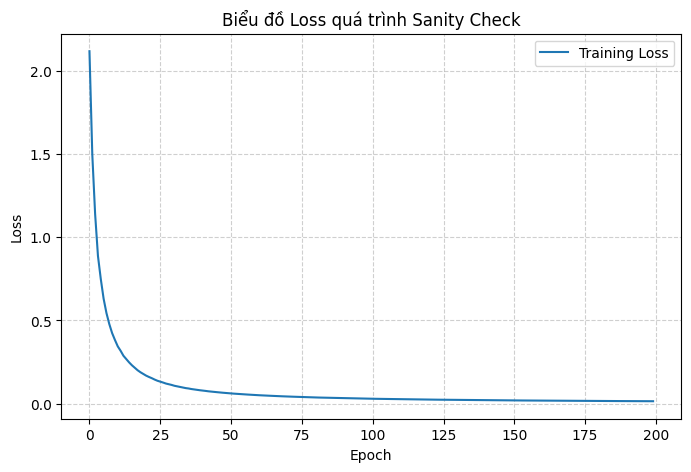

In [9]:
# 1. Chọn một tập hợp con nhỏ từ dữ liệu THỰC
subset_size = 100
X_subset = X_train[:subset_size]
y_subset_enc = y_train_enc[:subset_size]
y_subset_labels = y_train[:subset_size] # Nhãn gốc để kiểm tra độ chính xác

print(f"Kích thước tập Sanity Check: {X_subset.shape}")

# 2. Khởi tạo mô hình
# 784 đặc trưng (pixels), 10 lớp (số 0-9)
# Learning rate cao (0.1) để hội tụ nhanh trên tập nhỏ
model_check = SoftmaxRegression(n_features=784, n_classes=10, learning_rate=0.1)

# 3. Huấn luyện trên tập con (Cố tình Overfit)
print("\nBắt đầu Sanity Check...")
# Chạy 200 epochs để đảm bảo loss giảm sâu
model_check.fit(X_subset, y_subset_enc, epochs=200, batch_size=20, verbose=True)

# 4. Kiểm tra độ chính xác dự đoán
preds = model_check.predict(X_subset)
acc = np.mean(preds == y_subset_labels)
print(f"\nĐộ chính xác Sanity Check: {acc * 100:.2f}%")

# 5. Đánh giá kết quả
if acc > 0.95:
    print("✅ Sanity Check THÀNH CÔNG: Logic mô hình chính xác.")
else:
    print("❌ Sanity Check THẤT BẠI: Mô hình không thể học được dữ liệu nhỏ.")

# 6. Vẽ biểu đồ Loss
plt.figure(figsize=(8, 5))
plt.plot(model_check.losses, label='Training Loss')
plt.title("Biểu đồ Loss quá trình Sanity Check")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 5.1. Nhận xét & Giải thích kết quả Sanity Check

**Kết quả quan sát:**
* **Loss (Hàm mất mát):** Giảm mạnh từ mức khởi điểm (khoảng 2.2) xuống gần 0 (0.0144) sau 200 epochs. Đường cong Loss (Loss Curve) có dạng tiệm cận, mượt mà và không có dấu hiệu dao động bất thường.
* **Accuracy (Độ chính xác):** Đạt tuyệt đối **100%** trên tập dữ liệu nhỏ 100 mẫu.

**Tại sao việc "học thuộc lòng" (Overfitting) lại chứng minh code đúng?**
Trong thực tế, Overfitting là điều cần tránh. Tuy nhiên, ở bước kiểm thử (debugging) này, việc mô hình có thể Overfit là một **tín hiệu tốt** vì những lý do sau:

1.  **Xác minh tính đúng đắn của Thuật toán (Algorithm Verification):**
    * Mô hình Softmax Regression về bản chất là một bộ phân loại tuyến tính có khả năng biểu diễn (capacity) đủ lớn để phân biệt một lượng nhỏ các mẫu dữ liệu, miễn là các mẫu đó không bị trùng lặp mâu thuẫn (ví dụ: cùng một ảnh $x$ nhưng có 2 nhãn $y$ khác nhau).
    * Nếu code tính toán Gradient (`backward`) hoặc cập nhật trọng số (`update rules`) bị sai (ví dụ: sai dấu cộng/trừ, sai công thức đạo hàm), mô hình sẽ **không bao giờ** hội tụ được về Loss = 0, bất kể chạy bao lâu.
    * Việc Loss về gần 0 chứng tỏ hướng di chuyển của Gradient Descent là chính xác tuyệt đối.

2.  **Kiểm tra luồng dữ liệu (Data Pipeline Integrity):**
    * Kết quả này xác nhận rằng dữ liệu đầu vào ($X$) và nhãn ($y$) đã được xử lý đúng (khớp kích thước ma trận, đúng thứ tự one-hot encoding). Nếu nhãn bị lệch so với ảnh, mô hình sẽ rất khó học thuộc lòng.

**Kết luận:**
Logic toán học và code cài đặt của class `SoftmaxRegression` hoàn toàn chính xác. Chúng ta đủ tự tin để chuyển sang giai đoạn tiếp theo: Thiết kế đặc trưng và huấn luyện trên toàn bộ dữ liệu.

# LƯU Ý

Vì nhóm sẽ thực hiện thiết kế Feature Vector và thực hành thí nghiệm ở một notebook khác nên nhóm quyết định sẽ tạo folder lib chứa các module .py bao gồm lớp SoftmaxRegression (copy lại từ notebook này) và các helper functions (copy lại từ notebook này và thêm một số hàm tính các chỉ số đánh giá).